In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit, Poisson
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 70)
print("ECON 5140 - HOMEWORK 1")
print("Part A: Generalized Linear Models")
print("Part B: Time Series Decomposition")
print("=" * 70)

ECON 5140 - HOMEWORK 1
Part A: Generalized Linear Models
Part B: Time Series Decomposition


In [10]:
# ====================================================================
# DATASET 1: CUSTOMER PURCHASE DATA (for GLM analysis)
# ====================================================================
print("\n" + "=" * 70)
print("DATASET 1: Customer Purchase Behavior")
print("=" * 70)

n_customers = 1000

# Generate customer features
age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers)  # in thousands
time_on_site = np.random.gamma(2, 3, n_customers)  # in minutes

# True relationship (latent variable)
z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n_customers)

# Generate binary outcome (Purchase: 1=Yes, 0=No)
purchase = (z > 0).astype(int)

# Create DataFrame
df_customers = pd.DataFrame({
    'Age': age,
    'Income': income,
    'TimeOnSite': time_on_site,
    'Purchase': purchase
})

print(f"Number of customers: {len(df_customers)}")
print(f"Purchase rate: {df_customers['Purchase'].mean():.2%}")
print(f"\nFirst 5 rows:")
print(df_customers.head())



DATASET 1: Customer Purchase Behavior
Number of customers: 1000
Purchase rate: 89.20%

First 5 rows:
         Age     Income  TimeOnSite  Purchase
0  44.488652  59.948276    5.331184         1
1  31.207541  58.283927    3.766722         1
2  32.468784  25.310917    5.460144         0
3  25.209779  49.614467   15.576600         1
4  42.613424  24.564208    6.470302         1


In [11]:
# ====================================================================
# DATASET 2: E-COMMERCE SALES TIME SERIES
# ====================================================================
print("\n" + "=" * 70)
print("DATASET 2: E-commerce Daily Sales")
print("=" * 70)

# Create 2 years of daily data
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)

# Components
trend = 1000 + 2*t + 0.01*t**2
yearly_seasonal = 200 * np.sin(2*np.pi*t/365) + 150 * np.cos(2*np.pi*t/365)
weekly_seasonal = 100 * np.sin(2*np.pi*t/7)

# Special events
special_events = np.zeros(n_days)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    bf_idx = (dates == bf_date)
    special_events[bf_idx] = 800
    
    # Christmas
    xmas_idx = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    special_events[xmas_idx] = 400

# Random noise
noise = np.random.normal(0, 50, n_days)

# Combine components
sales = trend + yearly_seasonal + weekly_seasonal + special_events + noise
sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'DayOfWeek': dates.dayofweek,
    'Month': dates.month,
    'IsWeekend': dates.dayofweek >= 5
})
df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of days: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())



DATASET 2: E-commerce Daily Sales
Date range: 2024-01-01 to 2025-12-31
Number of days: 731

Sales Statistics:
count     731.000000
mean     3516.928018
std      1974.342760
min      1069.067152
25%      1590.962564
50%      3268.145837
75%      4954.142995
max      8329.500797
Name: Sales, dtype: float64



PART A: GENERALIZED LINEAR MODELS

----------------------------------------------------------------------
A1: Exploratory Data Analysis
----------------------------------------------------------------------


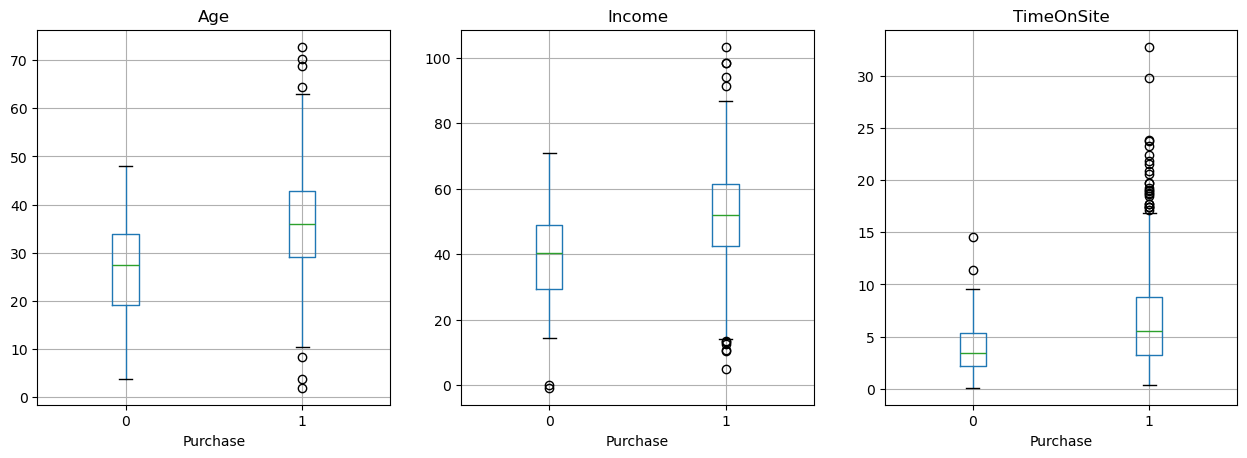

                Age     Income  TimeOnSite
Purchase                                  
0         26.888381  39.426375    4.043628
1         35.900547  51.716031    6.482655

----------------------------------------------------------------------
A2: Linear Probability Model
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     68.07
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           4.82e-40
Time:                        22:32:47   Log-Likelihood:                -155.73
No. Observations:                1000   AIC:                             319.5
Df Residuals:                     996   BIC:                             339.1
Df Model:               

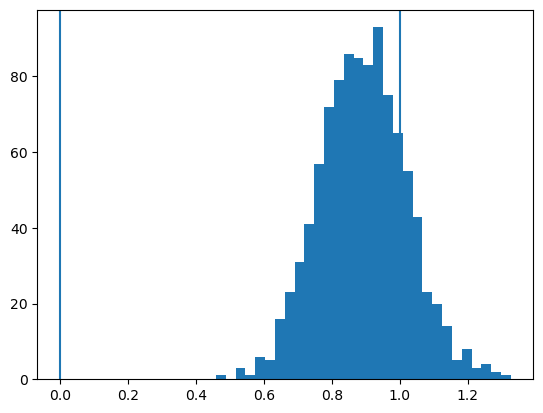


----------------------------------------------------------------------
A3: Logistic Regression
----------------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.240007
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Wed, 28 Jan 2026   Pseudo R-squ.:                  0.2989
Time:                        22:32:48   Log-Likelihood:                -240.01
converged:                       True   LL-Null:                       -342.31
Covariance Type:            nonrobust   LLR p-value:                 4.252e-44
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------

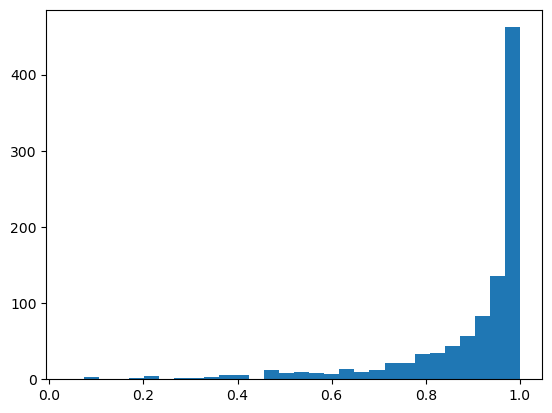


----------------------------------------------------------------------
A4: Predictions for New Customers
----------------------------------------------------------------------
   Age  Income  TimeOnSite  Predicted_Prob  Purchase
0   25      30           2        0.361350         0
1   35      50           5        0.947714         1
2   45      70           8        0.998281         1
3   55      90          10        0.999930         1


In [15]:
# ====================================================================
# PART A: GENERALIZED LINEAR MODELS
# ====================================================================
print("\n" + "=" * 70)
print("PART A: GENERALIZED LINEAR MODELS")
print("=" * 70)

# --------------------------------------------------------------------
# A1: Exploratory Data Analysis (GLM)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A1: Exploratory Data Analysis")
print("-" * 70)

# YOUR CODE:
# 1. Create box plots comparing Age, Income, and TimeOnSite; between purchasers and non-purchasers; Use 3 subplots (1 row, 3 columns)
# 2. Calculate and print mean values for each group:
#    - Mean Age: Purchasers vs Non-purchasers
#    - Mean Income: Purchasers vs Non-purchasers
#    - Mean TimeOnSite: Purchasers vs Non-purchasers
# 3. Create a correlation matrix heatmap for the features

df = pd.DataFrame({
    "Age": age,
    "Income": income,
    "TimeOnSite": time_on_site,
    "Purchase": purchase
})

fig, axes = plt.subplots(1,3, figsize=(15,5))
df.boxplot(column="Age", by="Purchase", ax=axes[0])
df.boxplot(column="Income", by="Purchase", ax=axes[1])
df.boxplot(column="TimeOnSite", by="Purchase", ax=axes[2])
plt.suptitle("")
plt.show()

print(df.groupby("Purchase").mean()
     )
#

# --------------------------------------------------------------------
# A2: Linear Probability Model (LPM)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A2: Linear Probability Model")
print("-" * 70)

X = sm.add_constant(df[["Age","Income","TimeOnSite"]])
y = df["Purchase"]

lpm = sm.OLS(y, X).fit()
print(lpm.summary())

pred_lpm = lpm.predict(X)
invalid = np.mean((pred_lpm < 0) | (pred_lpm > 1))
print(f"Invalid predictions: {invalid:.2%}")

plt.hist(pred_lpm, bins=30)
plt.axvline(0)
plt.axvline(1)
plt.show()


# --------------------------------------------------------------------
# A3: Logistic Regression
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A3: Logistic Regression")
print("-" * 70)

logit = sm.Logit(y, X).fit()
print(logit.summary())

odds_ratios = np.exp(logit.params)
print("Odds Ratios:\n", odds_ratios)

pred_logit = logit.predict(X)
plt.hist(pred_logit, bins=30)
plt.show()

# --------------------------------------------------------------------
# A4: Prediction for New Customers
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A4: Predictions for New Customers")
print("-" * 70)

# New customers
new_customers = pd.DataFrame({
    'Age': [25, 35, 45, 55],
    'Income': [30, 50, 70, 90],
    'TimeOnSite': [2, 5, 8, 10]
})

new_customers = pd.DataFrame({
    "Age": [25,35,45,55],
    "Income": [30,50,70,90],
    "TimeOnSite": [2,5,8,10]
})

X_new = sm.add_constant(new_customers)
new_customers["Predicted_Prob"] = logit.predict(X_new)
new_customers["Purchase"] = (new_customers["Predicted_Prob"] > 0.5).astype(int)

print(new_customers)


----------------------------------------------------------------------
B1: Time Series Visualization
----------------------------------------------------------------------


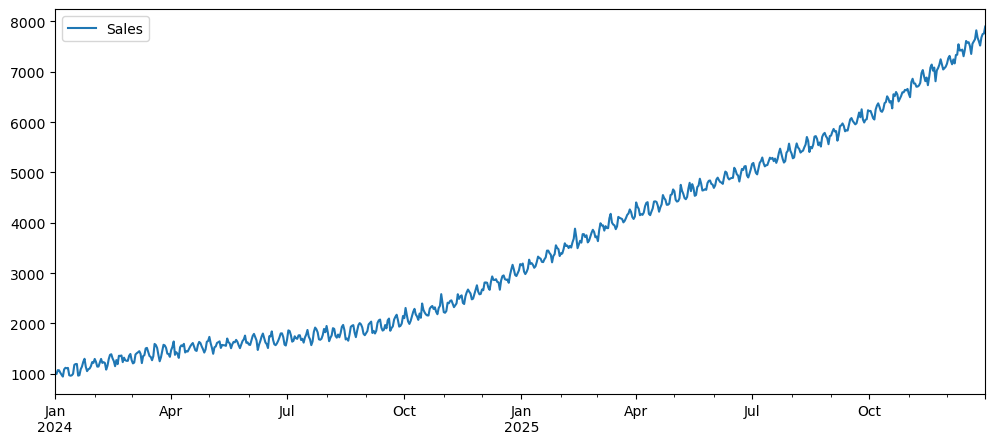

Sales are continously increasing since Jan 2024

----------------------------------------------------------------------
B2: Stationarity Check
----------------------------------------------------------------------


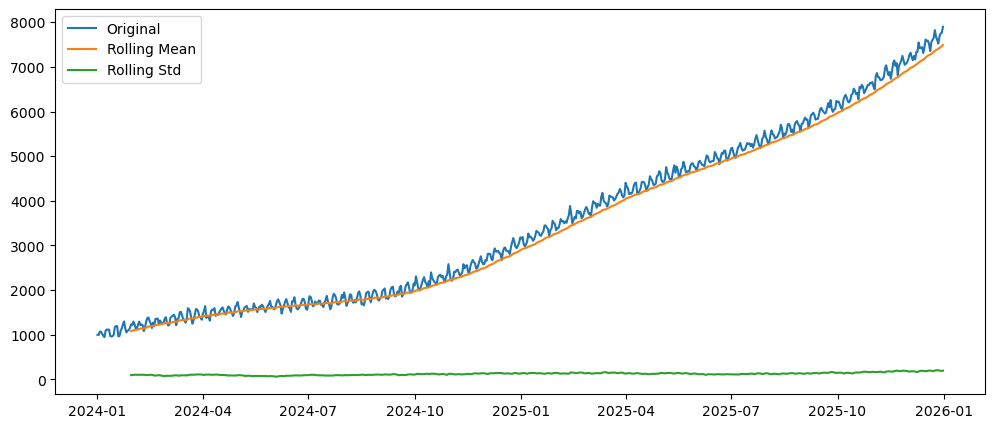

Is the series stationary?: The series is non stationary as the mean grows in line with the sales trend, even though rolling standard deviation is constant

----------------------------------------------------------------------
B3: Autocorrelation Function
----------------------------------------------------------------------


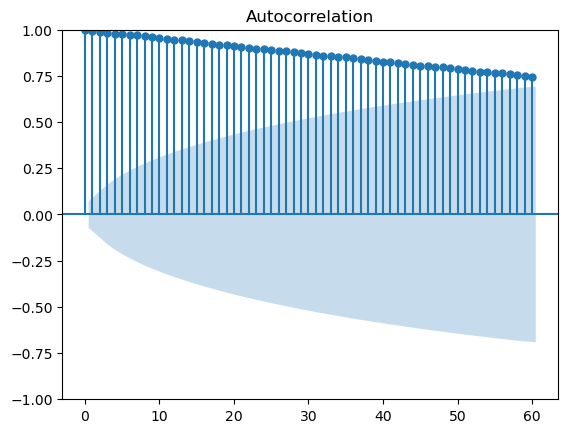

Lag 1 autocorrelation: 0.999
Do you see weekly patterns?: There appears to be subtle seasonality, but more investigation is needed to confirm
How persistent is the autocorrelation?: Extremely high—autocorrelations remain above 0.75, indicating strong non-stationarity
Lag 7 autocorrelation: 0.999
Do you see weekly patterns?: There appears to be subtle seasonality, but more investigation is needed to confirm
How persistent is the autocorrelation?: Extremely high—autocorrelations remain above 0.75, indicating strong non-stationarity
Lag 30 autocorrelation: 0.997
Do you see weekly patterns?: There appears to be subtle seasonality, but more investigation is needed to confirm
How persistent is the autocorrelation?: Extremely high—autocorrelations remain above 0.75, indicating strong non-stationarity

----------------------------------------------------------------------
B4: STL Decomposition
----------------------------------------------------------------------


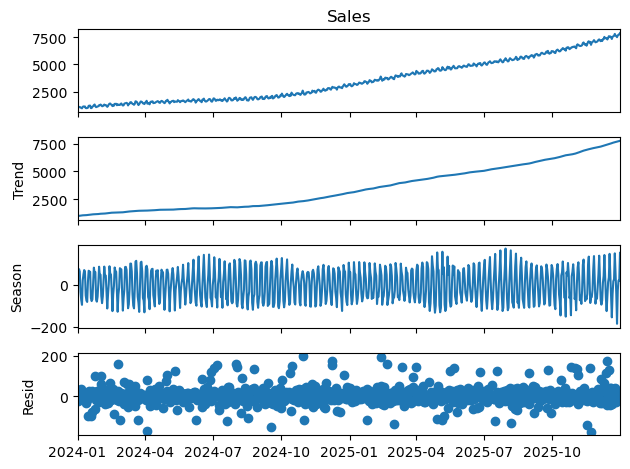

What is the trend pattern?: Strong positive linear growth from ~1,000 to ~7,500 over two years, with slight acceleration in the second half.
What is the weekly seasonal pattern?: Consistent movements between -100 and +100, showing stable weekly cycles throughout the entire period.
Are special events visible in remainder?: Yes, there are scattered outliers exceeding ±100, while most reflect tightly around zero indicating good model fit.

----------------------------------------------------------------------
B5: Remainder Analysis
----------------------------------------------------------------------


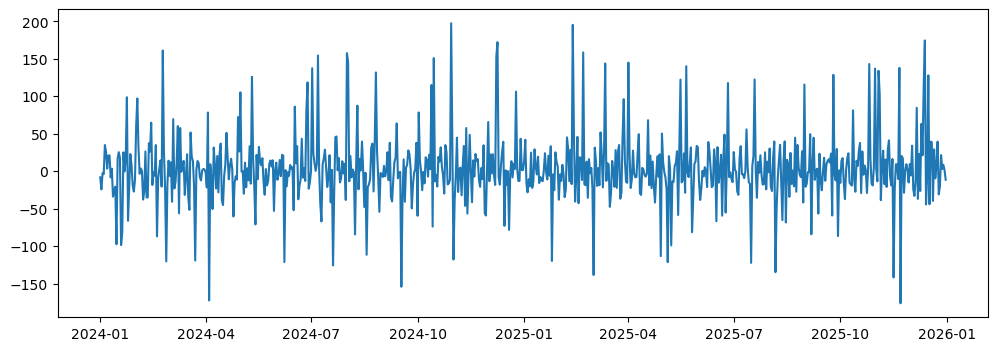

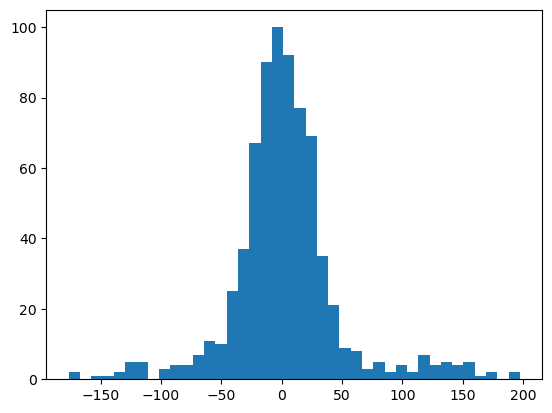

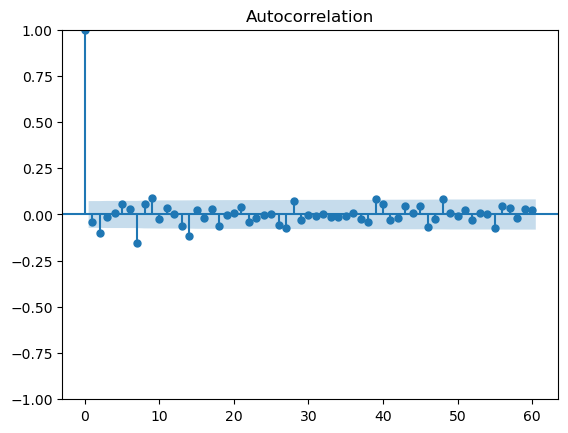

Outliers:
 2024-02-24    161.031708
2024-04-04   -172.474571
2024-07-02    137.418349
2024-07-07    154.422588
2024-08-01    157.538114
2024-08-02    145.561376
2024-09-17   -154.183359
2024-10-15    150.942616
2024-10-30    197.365952
2024-12-08    153.383254
2024-12-09    172.060395
2025-02-12    195.286332
2025-02-21    158.524732
2025-03-02   -138.516633
2025-03-12    143.771522
2025-04-01    144.875501
2025-05-21    140.098724
2025-10-26    142.981374
2025-11-16   -141.755609
2025-11-21    137.802685
2025-11-22   -176.252662
2025-12-13    174.479629
Name: resid, dtype: float64
Are Black Friday and Christmas visible?: Not exactly - 2024 shows high sales in October, no Nov and Dec data. 2025 shows very low sales in Oct and Nov, but high in Dec. This could be because the data is synthetic and not reality


In [35]:
# --------------------------------------------------------------------
# B1: Time Series Visualization
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B1: Time Series Visualization")
print("-" * 70)

dates = pd.date_range("2024-01-01", "2025-12-31", freq="D")
t = np.arange(len(dates))

trend = 1000 + 2*t + 0.01*t**2
yearly = 200*np.sin(2*np.pi*t/365)
weekly = 100*np.sin(2*np.pi*t/7)
noise = np.random.normal(0,50,len(t))

sales = trend + yearly + weekly + noise
sales = np.maximum(sales,0)

df_sales = pd.DataFrame({"Sales": sales}, index=dates)

df_sales.plot(figsize=(12,5))
plt.show()

print ("Sales are continously increasing since Jan 2024")

# --------------------------------------------------------------------
# B2: Stationarity Assessment
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B2: Stationarity Check")
print("-" * 70)

rolling_mean = df_sales["Sales"].rolling(30).mean()
rolling_std = df_sales["Sales"].rolling(30).std()

plt.figure(figsize=(12,5))
plt.plot(df_sales["Sales"], label="Original")
plt.plot(rolling_mean, label="Rolling Mean")
plt.plot(rolling_std, label="Rolling Std")
plt.legend()
plt.show()

print("Is the series stationary?: The series is non stationary as the mean grows in line with the sales trend, even though rolling standard deviation is constant")

# --------------------------------------------------------------------
# B3: Autocorrelation Analysis
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B3: Autocorrelation Function")
print("-" * 70)

plot_acf(df_sales["Sales"], lags=60)
plt.show()

for lag in [1,7,30]:
    corr = np.corrcoef(sales[:-lag], sales[lag:])[0,1]
    print(f"Lag {lag} autocorrelation: {corr:.3f}")
    
    print("Do you see weekly patterns?: There appears to be subtle seasonality, but more investigation is needed to confirm")
    print("How persistent is the autocorrelation?: Extremely high—autocorrelations remain above 0.75, indicating strong non-stationarity")

# --------------------------------------------------------------------
# B4: STL Decomposition
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B4: STL Decomposition")
print("-" * 70)

stl = STL(df_sales["Sales"], seasonal=7, robust=True)
res = stl.fit()
res.plot()
plt.show()

print("What is the trend pattern?: Strong positive linear growth from ~1,000 to ~7,500 over two years, with slight acceleration in the second half.")
print("What is the weekly seasonal pattern?: Consistent movements between -100 and +100, showing stable weekly cycles throughout the entire period.")
print("Are special events visible in remainder?: Yes, there are scattered outliers exceeding ±100, while most reflect tightly around zero indicating good model fit.")

# --------------------------------------------------------------------
# B5: Remainder Diagnostics
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B5: Remainder Analysis")
print("-" * 70)

remainder = res.resid

plt.figure(figsize=(12,4))
plt.plot(remainder)
plt.show()

plt.hist(remainder, bins=40)
plt.show()

plot_acf(remainder, lags=60)
plt.show()

std = remainder.std()
outliers = remainder[np.abs(remainder) > 3*std]
print("Outliers:\n", outliers)

print("Are Black Friday and Christmas visible?: Not exactly - 2024 shows high sales in October, no Nov and Dec data. 2025 shows very low sales in Oct and Nov, but high in Dec. This could be because the data is synthetic and not reality")